In [43]:
#@title Copyright 2023 Google LLC. Double-click for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Clasificación binaria 

En este notebook, completarás las siguientes tareas:

- Examinar un conjunto de datos que contiene mediciones derivadas de imágenes de dos especies de arroz turco.
- Crear un clasificador binario para clasificar los granos de arroz en las dos especies.
- Evaluar el rendimiento del modelo.


## Objetivos de aprendizaje

Al completar este notebook, aprenderás:

- Cómo entrenar un clasificador binario.
- Cómo calcular métricas para un clasificador binario en diferentes umbrales.
- Cómo comparar AUC y ROC de dos modelos diferentes.


## Dataset

Este Notebook utiliza el conjunto de datos de arroz Cinar y Koklu 2019 Osmancik y Cammeo.

Se proporciona una licencia CC0 (consulte [Kaggle](https://www.kaggle.com/datasets/muratkokludataset/rice-dataset-commeo-and-osmancik)para obtener más documentación; las longitudes y el área se dan en píxeles). Cinar y Koklu también proporcionan conjuntos de datos para multiclase (5 especies de arroz), pistachos, pasas, hojas de uva, etc., en su [repositorio](https://www.muratkoklu.com/datasets/).

### Cita

Cinar, I. and Koklu, M., (2019). “Classification of Rice Varieties Using Artificial Intelligence Methods.” *International Journal of Intelligent Systems and Applications in Engineering*, 7(3), 188-194.

DOI: https://doi.org/10.18201/ijisae.2019355381


# Instalar bibliotecas requeridas

In [44]:
# @title Install required libraries

!pip install google-ml-edu==0.1.2 \
    keras~=3.8.0 \
    matplotlib~=3.10.0 \
    numpy~=2.0.0 \
    pandas~=2.2.0 \
    tensorflow~=2.18.0

print('\n\nAll requirements successfully installed.')



All requirements successfully installed.


In [45]:
# @title Load the imports

import keras
import ml_edu.experiment
import ml_edu.results
import numpy as np
import pandas as pd
import plotly.express as px

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Ran the import statements.")

Ran the import statements.


In [46]:
# @title Load the dataset
rice_dataset_raw = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/Rice_Cammeo_Osmancik.csv")

Una vez que el conjunto de datos se haya cargado a través de la celda anterior, seleccione columnas específicas para mostrar estadísticas de resumen de las características numéricas del conjunto de datos.

Consulte la  [dataset documentation](https://www.kaggle.com/datasets/muratkokludataset/rice-dataset-commeo-and-osmancik), especialmente la sección **Procedencia**, para obtener explicaciones de lo que significa cada característica y cómo se calcularon.

In [47]:
# @title
# Read and provide statistics on the dataset.
rice_dataset = rice_dataset_raw[[
    'Area',
    'Perimeter',
    'Major_Axis_Length',
    'Minor_Axis_Length',
    'Eccentricity',
    'Convex_Area',
    'Extent',
    'Class',
]]

rice_dataset.describe()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.0,3810.0,3810.0,3810.0,3810.0,3810.0,3810.0
mean,12667.7,454.2,188.8,86.3,0.9,12952.5,0.7
std,1732.4,35.6,17.4,5.7,0.0,1777.0,0.1
min,7551.0,359.1,145.3,59.5,0.8,7723.0,0.5
25%,11370.5,426.1,174.4,82.7,0.9,11626.2,0.6
50%,12421.5,448.9,185.8,86.4,0.9,12706.5,0.6
75%,13950.0,483.7,203.6,90.1,0.9,14284.0,0.7
max,18913.0,548.4,239.0,107.5,0.9,19099.0,0.9


## Tarea 1: Describir los datos

De las estadísticas de resumen anteriores, responda las siguientes preguntas:

- ¿Cuáles son las longitudes mínima y máxima (longitud del eje principal, dada en píxeles) de los granos de arroz?
- ¿Cuál es la gama de áreas entre los granos de arroz más pequeños y más grandes?
- ¿Cuántas desviaciones estándar (std) ¿es el mayor perímetro de grano de arroz de la media?


In [48]:
# @title Solutions (run the cell to get the answers)

print(
    f'The shortest grain is {rice_dataset.Major_Axis_Length.min():.1f}px long,'
    f' while the longest is {rice_dataset.Major_Axis_Length.max():.1f}px.'
)
print(
    f'The smallest rice grain has an area of {rice_dataset.Area.min()}px, while'
    f' the largest has an area of {rice_dataset.Area.max()}px.'
)
print(
    'The largest rice grain, with a perimeter of'
    f' {rice_dataset.Perimeter.max():.1f}px, is'
    f' ~{(rice_dataset.Perimeter.max() - rice_dataset.Perimeter.mean())/rice_dataset.Perimeter.std():.1f} standard'
    f' deviations ({rice_dataset.Perimeter.std():.1f}) from the mean'
    f' ({rice_dataset.Perimeter.mean():.1f}px).'
)
print(
    f'This is calculated as: ({rice_dataset.Perimeter.max():.1f} -'
    f' {rice_dataset.Perimeter.mean():.1f})/{rice_dataset.Perimeter.std():.1f} ='
    f' {(rice_dataset.Perimeter.max() - rice_dataset.Perimeter.mean())/rice_dataset.Perimeter.std():.1f}'
)

The shortest grain is 145.3px long, while the longest is 239.0px.
The smallest rice grain has an area of 7551px, while the largest has an area of 18913px.
The largest rice grain, with a perimeter of 548.4px, is ~2.6 standard deviations (35.6) from the mean (454.2px).
This is calculated as: (548.4 - 454.2)/35.6 = 2.6


# Explore el conjunto de datos

Traza algunas de las características unas contra otras, incluso en 3D.



In [49]:
# Create five 2D plots of the features against each other, color-coded by class.
for x_axis_data, y_axis_data in [
    ('Area', 'Eccentricity'),
    ('Convex_Area', 'Perimeter'),
    ('Major_Axis_Length', 'Minor_Axis_Length'),
    ('Perimeter', 'Extent'),
    ('Eccentricity', 'Major_Axis_Length'),
]:
  px.scatter(rice_dataset, x=x_axis_data, y=y_axis_data, color='Class').show()

## Task 2: Tarea 2: Visualizar muestras en 3D

Intente graficar tres de las características en 3D entre sí.


In [50]:
#@title Plot three features in 3D by entering their names and running this cell

x_axis_data = 'Area'  # @param {type: "string"}
y_axis_data = 'Perimeter'  # @param {type: "string"}
z_axis_data = 'Eccentricity'  # @param {type: "string"}

px.scatter_3d(
    rice_dataset,
    x=x_axis_data,
    y=y_axis_data,
    z=z_axis_data,
    color='Class',
).show()

In [51]:
# @title One possible solution

# Plot major and minor axis length and eccentricity, with observations
# color-coded by class.
px.scatter_3d(
    rice_dataset,
    x='Eccentricity',
    y='Area',
    z='Major_Axis_Length',
    color='Class',
).show()

Si tuviéramos que elegir tres características, parece que la longitud del eje mayor, el área y la excentricidad podrían contener la mayor parte de la información que diferencia a las dos clases. Otras combinaciones también pueden funcionar.

Ejecute la celda de código anterior para graficar esas tres características si aún no lo ha hecho.

Parece que un límite de clase distinto aparece en el plano de estas tres características. Entrenaremos un modelo solo en estas características, luego otro modelo en el conjunto completo de características, y compararemos su rendimiento.

## Normalize data

Normalizar los datos

Al crear un modelo con múltiples características, los valores de cada característica deben abarcar aproximadamente el mismo rango. Si los valores de una característica oscilan entre 500 y 100.000 y los valores de otra característica oscilan entre 2 y 12, el modelo necesitará tener pesos de valores extremadamente bajos o extremadamente altos para poder combinar estas características de manera efectiva. Esto podría resultar en un modelo de baja calidad. Para evitar esto,
[normalizar](https://developers.google.com/machine-learning/glossary/#normalization) las características en un modelo multi-función.

Esto se puede hacer convirtiendo cada valor bruto en su **puntuación Z**. La puntuación Z para un valor dado es cuántas desviaciones estándar de la media es el valor.

Considere una característica con una media de 60 y una desviación estándar de 10.

El valor bruto 75 tendría una puntuación Z de +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

El valor bruto 38 tendría una puntuación Z de -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2
```

Ahora normaliza los valores numéricos en el conjunto de datos de arroz convirtiéndolos en puntuaciones Z.

In [52]:
# Calculate the Z-scores of each numerical column in the raw data and write
# them into a new DataFrame named df_norm.

feature_mean = rice_dataset.mean(numeric_only=True)
feature_std = rice_dataset.std(numeric_only=True)
numerical_features = rice_dataset.select_dtypes('number').columns
normalized_dataset = (
    rice_dataset[numerical_features] - feature_mean
) / feature_std

# Copy the class to the new dataframe
normalized_dataset['Class'] = rice_dataset['Class']

# Examine some of the values of the normalized training set. Notice that most
# Z-scores fall between -2 and +2.
normalized_dataset.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,1.5,2.0,2.3,-0.2,2.0,1.5,-1.2,Cammeo
1,1.1,1.1,1.0,0.9,0.4,1.2,-0.6,Cammeo
2,1.1,1.3,1.5,0.3,1.2,1.1,0.4,Cammeo
3,0.3,0.1,0.3,0.2,0.2,0.2,-0.3,Cammeo
4,1.2,1.5,1.3,0.5,1.0,1.3,-0.2,Cammeo


# Establecer las semillas aleatorias 

Para hacer que los experimentos sean reproducibles, establecemos la semilla de los generadores de números aleatorios. Esto significa que el orden en el que se barajan los datos, los valores de las inicializaciones de peso aleatorio, etc., serán todos iguales cada vez que se ejecute el colab.

In [53]:
keras.utils.set_random_seed(42)

## Etiqueta y divide los datos

Para entrenar el modelo, asignaremos arbitrariamente a la especie Cammeo una etiqueta de '1' y la especie Osmancik una etiqueta de '0'.

In [54]:
# Create a column setting the Cammeo label to '1' and the Osmancik label to '0'
# then show 10 randomly selected rows.
normalized_dataset['Class_Bool'] = (
    # Returns true if class is Cammeo, and false if class is Osmancik
    normalized_dataset['Class'] == 'Cammeo'
).astype(int)
normalized_dataset.sample(10)

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,Class_Bool
1011,-0.1,0.1,-0.1,0.2,-0.1,-0.0,-1.0,Cammeo,1
3185,-0.1,-0.5,-0.5,0.4,-0.8,-0.2,-0.3,Osmancik,0
3698,0.1,-0.1,-0.4,0.9,-1.1,0.1,-0.2,Osmancik,0
897,0.2,0.5,0.8,-0.5,1.2,0.2,1.5,Cammeo,1
3245,-1.3,-1.3,-0.9,-1.6,0.5,-1.4,-1.1,Osmancik,0
478,0.2,0.2,0.4,-0.0,0.5,0.2,1.7,Cammeo,1
1731,-0.4,-0.8,-0.8,0.3,-1.0,-0.5,-0.4,Osmancik,0
1025,0.6,0.7,0.6,0.3,0.5,0.6,-0.5,Cammeo,1
429,1.2,1.2,1.4,0.6,1.0,1.2,1.8,Cammeo,1
1330,-0.4,-0.0,0.4,-1.3,1.4,-0.5,-0.1,Cammeo,1


A continuación, podemos aleatorizar y dividir el conjunto de datos en tren, validación y divisiones de prueba, que consisten en 80%, 10% y 10% del conjunto de datos, respectivamente.

Utilizaremos los datos de entrenamiento para aprender los parámetros del modelo, luego usaremos los datos de validación para evaluar diferentes modelos y, finalmente, usaremos los datos de prueba para calcular las métricas finales para el modelo que mejor se desempeñó en los datos de validación.

In [55]:
# Create indices at the 80th and 90th percentiles
number_samples = len(normalized_dataset)
index_80th = round(number_samples * 0.8)
index_90th = index_80th + round(number_samples * 0.1)

# Randomize order and split into train, validation, and test with a .8, .1, .1 split
shuffled_dataset = normalized_dataset.sample(frac=1, random_state=100)
train_data = shuffled_dataset.iloc[0:index_80th]
validation_data = shuffled_dataset.iloc[index_80th:index_90th]
test_data = shuffled_dataset.iloc[index_90th:]

# Show the first five rows of the last split
test_data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,Class_Bool
2405,-0.4,-0.7,-0.8,0.3,-1.1,-0.4,0.3,Osmancik,0
3062,-0.2,-0.0,0.2,-0.7,0.8,-0.2,1.6,Osmancik,0
1155,1.4,1.2,1.1,1.2,0.3,1.3,0.7,Cammeo,1
660,1.2,1.0,0.8,1.3,-0.0,1.2,-0.6,Cammeo,1
2451,-1.2,-1.2,-1.4,-0.3,-1.5,-1.1,0.1,Osmancik,0


Es importante evitar que el modelo obtenga la etiqueta como entrada durante el entrenamiento, lo que se llama fuga de etiqueta. Esto se puede hacer almacenando características y etiquetas como variables separadas.

In [56]:
label_columns = ['Class', 'Class_Bool']

train_features = train_data.drop(columns=label_columns)
train_labels = train_data['Class_Bool'].to_numpy()
validation_features = validation_data.drop(columns=label_columns)
validation_labels = validation_data['Class_Bool'].to_numpy()
test_features = test_data.drop(columns=label_columns)
test_labels = test_data['Class_Bool'].to_numpy()

## Entrena el modelo

### Elige las características de entrada

Para empezar, vamos a entrenar a un modelo en `Eccentricity`, `Major_Axis_Length,` y `Area`.

In [57]:
# Name of the features we'll train our model on.
input_features = [
    'Eccentricity',
    'Major_Axis_Length',
    'Area',
]

## Definir funciones que construyan y entrenen un modelo 

La siguiente celda de código define dos funciones:

  * `create_model(inputs, learning_rate, metrics)`, que define la arquitectura del modelo.
  * `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`, utiliza características de entrada y etiquetas para entrenar el modelo.

Nota: create_model aplica la función sigmoide para realizar [logistic regression](https://developers.google.com/machine-learning/crash-course/logistic-regression).

También definimos dos estructuras de datos útiles: `ExperimentSettings` y `Experiment`. Utilizamos estas sencillas clases para realizar un seguimiento de nuestros experimentos, permitiéndonos saber qué hiperparámetros se utilizaron y cuáles fueron los resultados. En `ExperimentSettings`, almacenamos todos los valores que describen un experimento (es decir, hiperparámetros). Luego, almacenamos los resultados de una carrera de entrenamiento (es decir, el modelo y las métricas de entrenamiento) en una `Experiment`, junto con el `ExperimentSettings` se utiliza para ese experimento.

In [58]:
# @title Define the functions that create and train a model.


def create_model(
    settings: ml_edu.experiment.ExperimentSettings,
    metrics: list[keras.metrics.Metric],
) -> keras.Model:
  """Create and compile a simple classification model."""
  model_inputs = [
      keras.Input(name=feature, shape=(1,))
      for feature in settings.input_features
  ]
  # Use a Concatenate layer to assemble the different inputs into a single
  # tensor which will be given as input to the Dense layer.
  # For example: [input_1[0][0], input_2[0][0]]

  concatenated_inputs = keras.layers.Concatenate()(model_inputs)
  model_output = keras.layers.Dense(
      units=1, name='dense_layer', activation=keras.activations.sigmoid
  )(concatenated_inputs)
  model = keras.Model(inputs=model_inputs, outputs=model_output)
  # Call the compile method to transform the layers into a model that
  # Keras can execute.  Notice that we're using a different loss
  # function for classification than for regression.
  model.compile(
      optimizer=keras.optimizers.RMSprop(
          settings.learning_rate
      ),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics,
  )
  return model


def train_model(
    experiment_name: str,
    model: keras.Model,
    dataset: pd.DataFrame,
    labels: np.ndarray,
    settings: ml_edu.experiment.ExperimentSettings,
) -> ml_edu.experiment.Experiment:
  """Feed a dataset into the model in order to train it."""

  # The x parameter of keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.
  features = {
      feature_name: np.array(dataset[feature_name])
      for feature_name in settings.input_features
  }

  history = model.fit(
      x=features,
      y=labels,
      batch_size=settings.batch_size,
      epochs=settings.number_epochs,
  )

  return ml_edu.experiment.Experiment(
      name=experiment_name,
      settings=settings,
      model=model,
      epochs=history.epoch,
      metrics_history=pd.DataFrame(history.history),
  )


print('Defined the create_model and train_model functions.')

Defined the create_model and train_model functions.


## Definir una función de trazado

La siguiente función [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) traza una o más curvas, mostrando cómo cambian varias métricas de clasificación con cada época.

## Invocar las funciones de creación, entrenamiento y trazado

El siguiente código especifica los hiperparámetros, invoca el Funciones para crear y entrenar el modelo, luego traza los resultados, incluyendo la precisión, la precisión y el recuerdo.

El umbral de clasificación se establece en 0.35. Intente jugar con el umbral, luego la tasa de aprendizaje, para ver qué cambia.

Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6879 - auc: 0.8524 - loss: 0.5124 - precision: 0.5897 - recall: 0.9565   
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7115 - auc: 0.8697 - loss: 0.4899 - precision: 0.6103 - recall: 0.9537 
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7330 - auc: 0.8822 - loss: 0.4712 - precision: 0.6293 - recall: 0.9575 
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7512 - auc: 0.8931 - loss: 0.4537 - precision: 0.6473 - recall: 0.9551 
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7643 - auc: 0.9022 - loss: 0.4373 - precision: 0.6606 - recall: 0.9553
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7727 - auc: 0.9105 - loss: 0.4220 - precision: 0.6698 - recall: 0.9533 
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7829 - auc: 0.9176 - loss: 0.4076 - precision: 0.6812 - recall: 0.9521 
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

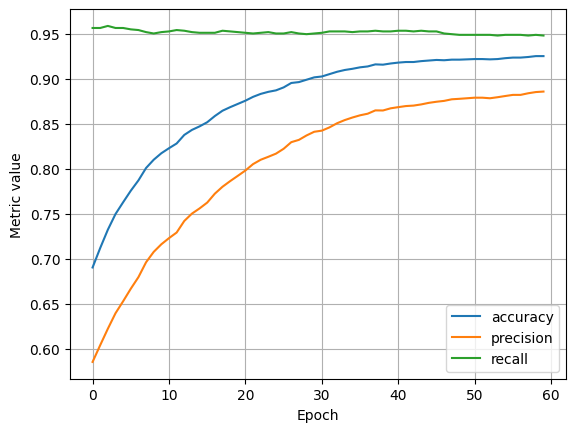

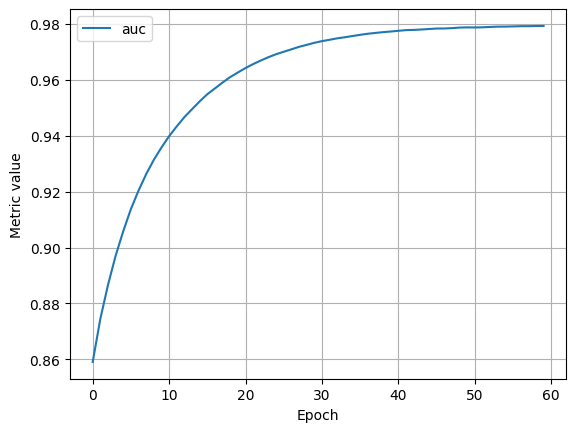

In [59]:
# Let's define our first experiment settings.
settings = ml_edu.experiment.ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.35,
    input_features=input_features,
)

metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy', threshold=settings.classification_threshold
    ),
    keras.metrics.Precision(
        name='precision', thresholds=settings.classification_threshold
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model = create_model(settings, metrics)

# Train the model on the training set.
experiment = train_model(
    'baseline', model, train_features, train_labels, settings
)

# Plot metrics vs. epochs
ml_edu.results.plot_experiment_metrics(experiment, ['accuracy', 'precision', 'recall'])
ml_edu.results.plot_experiment_metrics(experiment, ['auc'])

El AUC se calcula a través de todos los umbrales posibles (en la práctica en el código anterior, 100 umbrales), mientras que la precisión, la precisión y la recuperación se calculan solo para el umbral especificado. Por esta razón se muestran por separado arriba.

## Evaluar el modelo frente al conjunto validación 

Al final del *entrenamiento* del modelo, terminaste con una cierta precisión contra el *conjunto de entrenamiento*. Invoque la siguiente celda de código para determinar la precisión de su modelo con el *conjunto de validación*.

In [60]:
def compare_train_validation(experiment: ml_edu.experiment.Experiment, validation_metrics: dict[str, float]):
  print('Comparing metrics between train and validation:')
  for metric, validation_value in validation_metrics.items():
    print('------')
    print(f'Train {metric}: {experiment.get_final_metric_value(metric):.4f}')
    print(f'Validation {metric}:  {validation_value:.4f}')


# Evaluate validation metrics
validation_metrics = experiment.evaluate(validation_features, validation_labels)
compare_train_validation(experiment, validation_metrics)

Comparing metrics between train and validation:
------
Train accuracy: 0.9252
Validation accuracy:  0.8950
------
Train auc: 0.9793
Validation auc:  0.9722
------
Train loss: 0.1844
Validation loss:  0.2155
------
Train precision: 0.8858
Validation precision:  0.8449
------
Train recall: 0.9481
Validation recall:  0.9349


Parece que el modelo, que alcanzó una precisión de ~92% en los datos de entrenamiento, todavía muestra una precisión de aproximadamente el 90% en los datos de validación. ¿Podemos hacerlo mejor? Entrenemos un modelo utilizando las siete características disponibles y comparemos las AUC.

In [61]:
# Features used to train the model on.
# Specify all features.
all_input_features = [
  'Eccentricity',
  'Major_Axis_Length',
  'Minor_Axis_Length',
  'Area',
  'Perimeter',
  'Extent',
  'Aspect_Ratio',
]

In [62]:
#@title Solution
# Features used to train the model on.
# Specify all features.
all_input_features = [
  'Eccentricity',
  'Major_Axis_Length',
  'Minor_Axis_Length',
  'Area',
  'Convex_Area',
  'Perimeter',
  'Extent',
]

## Entrena el modelo con todas las funciones y calcula las métricas 

Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8803 - auc: 0.9524 - loss: 0.4140 - precision: 0.8317 - recall: 0.9142  
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8918 - auc: 0.9608 - loss: 0.3802 - precision: 0.8485 - recall: 0.9197
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8967 - auc: 0.9652 - loss: 0.3545 - precision: 0.8597 - recall: 0.9165 
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9000 - auc: 0.9680 - loss: 0.3323 - precision: 0.8654 - recall: 0.9170
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9067 - auc: 0.9700 - loss: 0.3131 - precision: 0.8767 - recall: 0.9179 
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9116 - auc: 0.9713 - loss: 0.2964 - precision: 0.8848 - recall: 0.9198 
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9125 - auc: 0.9723 - loss: 0.2819 - precision: 0.8859 - recall: 0.9205 
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

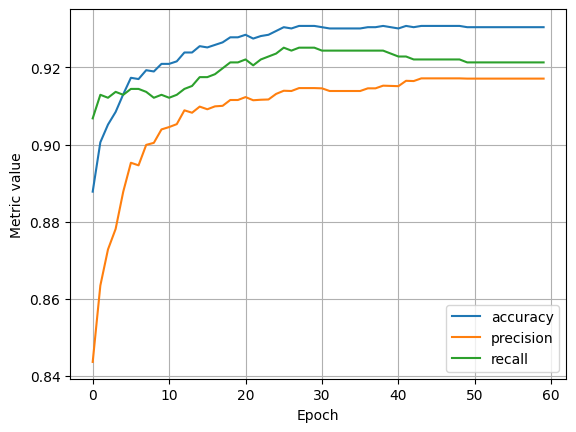

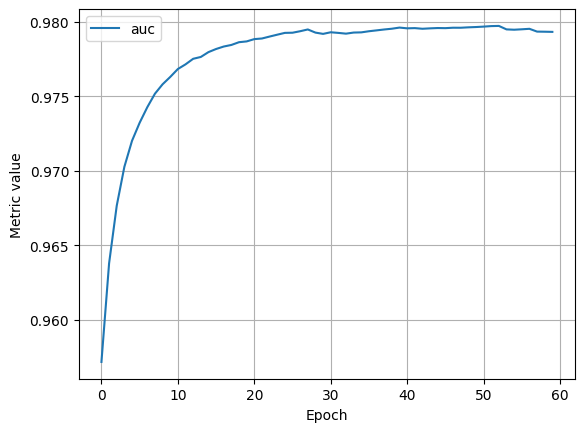

In [63]:
settings_all_features = ml_edu.experiment.ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.5,
    input_features=all_input_features,
)

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy',
        threshold=settings_all_features.classification_threshold,
    ),
    keras.metrics.Precision(
        name='precision',
        thresholds=settings_all_features.classification_threshold,
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings_all_features.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model_all_features = create_model(settings_all_features, metrics)

# Train the model on the training set.
experiment_all_features = train_model(
    'all features',
    model_all_features,
    train_features,
    train_labels,
    settings_all_features,
)

# Plot metrics vs. epochs
ml_edu.results.plot_experiment_metrics(
    experiment_all_features, ['accuracy', 'precision', 'recall']
)
ml_edu.results.plot_experiment_metrics(experiment_all_features, ['auc'])

## Evaluar el modelo con todas las funciones en la división de validación 

In [64]:
validation_metrics_all_features = experiment_all_features.evaluate(
    validation_features,
    validation_labels,
)
compare_train_validation(experiment_all_features, validation_metrics_all_features)

Comparing metrics between train and validation:
------
Train accuracy: 0.9304
Validation accuracy:  0.9108
------
Train auc: 0.9793
Validation auc:  0.9713
------
Train loss: 0.1790
Validation loss:  0.2155
------
Train precision: 0.9171
Validation precision:  0.8902
------
Train recall: 0.9213
Validation recall:  0.9112


Este segundo modelo tiene métricas de tren y validación más cercanas, lo que sugiere que se ajusta menos a los datos de entrenamiento.

# Comparando nuestros dos modelo

Con nuestro marco de experimentación simple, podemos hacer un seguimiento de qué experimentos realizamos y cuáles fueron los resultados. También se definió una función auxiliar que nos permite comparar fácilmente dos o más modelos, tanto durante el entrenamiento como cuando se evalúa en el conjunto de validación.

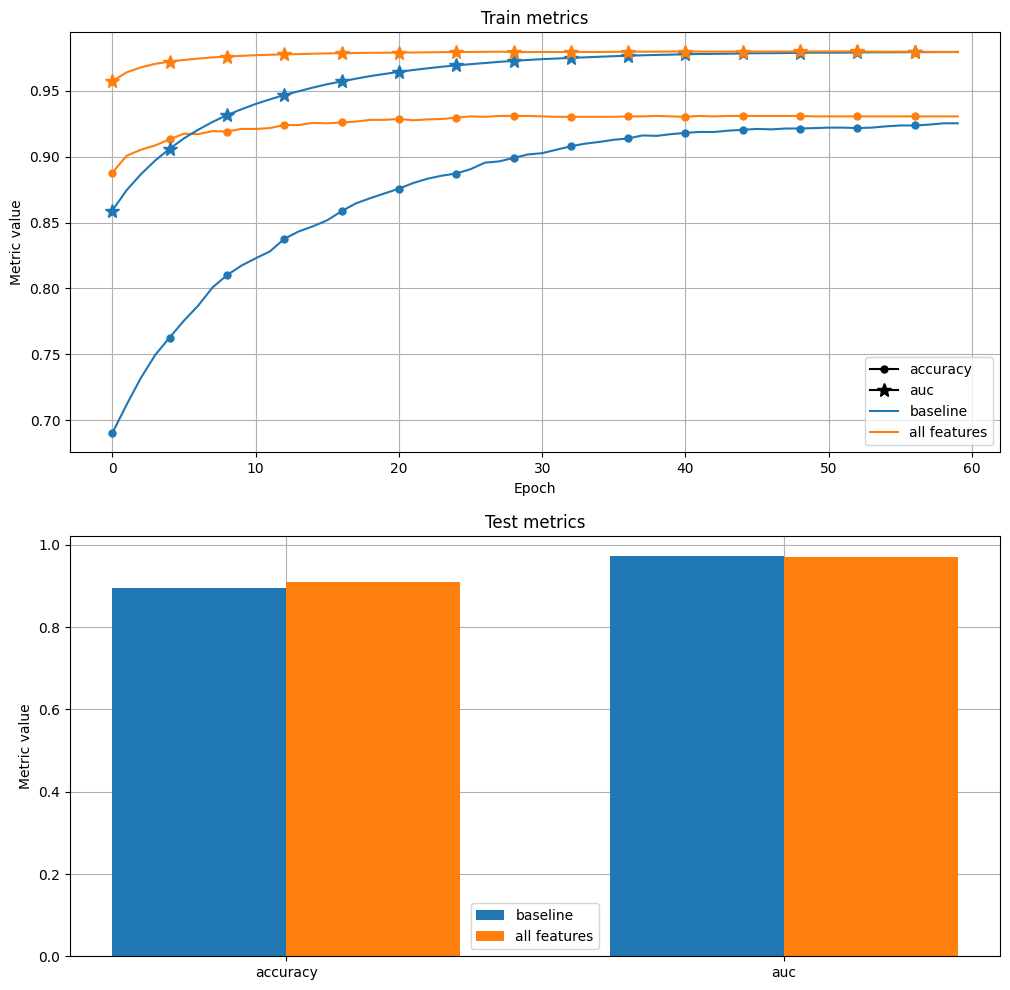

In [65]:
ml_edu.results.compare_experiment([experiment, experiment_all_features],
                                  ['accuracy', 'auc'],
                                  validation_features, validation_labels)

Comparando los dos modelos, ambos tienen AUC de ~.97-.98. No parece haber una gran ganancia en la calidad del modelo al agregar las otras cuatro características, lo que tiene sentido, dado que muchas de las características (área, perímetro y área convexa, por ejemplo) están interrelacionadas.

# Computar las métricas finales de la prueba

Para estimar la evolución de nuestro modelo sobre datos invisibles, ahora podemos calcular las métricas del mejor modelo en los datos de prueba. Este paso final debe hacerse una vez que la experimentación ha terminado y hemos seleccionado el modelo que queremos utilizar. Cualquier comparación de modelos debe hacerse utilizando el conjunto de validación, para evitar seleccionar accidentalmente un modelo que esté diseñado para nuestro conjunto de prueba.

Este paso final también es la oportunidad de verificar el posible sobreajuste: si las métricas de validación y prueba son muy diferentes, podría ser una señal de que el proceso de selección realizado utilizando el conjunto de validación condujo a un modelo que no se generaliza bien, posiblemente porque el conjunto de validación no es representativo de la distribución general de datos. En ese caso, la mejor solución es barajar los datos y reasignar el tren, la validación y los conjuntos de pruebas, antes de ejecutar sus experimentos nuevamente.


In [66]:
test_metrics_all_features = experiment_all_features.evaluate(
    test_features,
    test_labels,
)
for metric, test_value in test_metrics_all_features.items():
  print(f'Test {metric}:  {test_value:.4f}')

Test accuracy:  0.9213
Test auc:  0.9761
Test loss:  0.1900
Test precision:  0.9067
Test recall:  0.8947


En este caso, vemos que la precisión de la prueba es de aproximadamente el 92%, que está cerca de la precisión de validación que hemos obtenido anteriormente. ¡Esto significa que nuestro modelo debe funcionar igualmente bien con datos nuevos e invisibles!